In [183]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [184]:
# Load the teams data
dataset = pd.read_csv('./cleaned_data/dataset.csv')

label = 'PlayoffNextSeason'
features = [
    'CumulativePlayoffProgScore', '3P%', 'FT%',
    'OFFRTG', 'DEFRTG', 'AST RATIO',
    'REB%', 'TOV%', 'PACE', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach'
]

# Prepare feature and label data
X = dataset[features]
y = dataset[label]

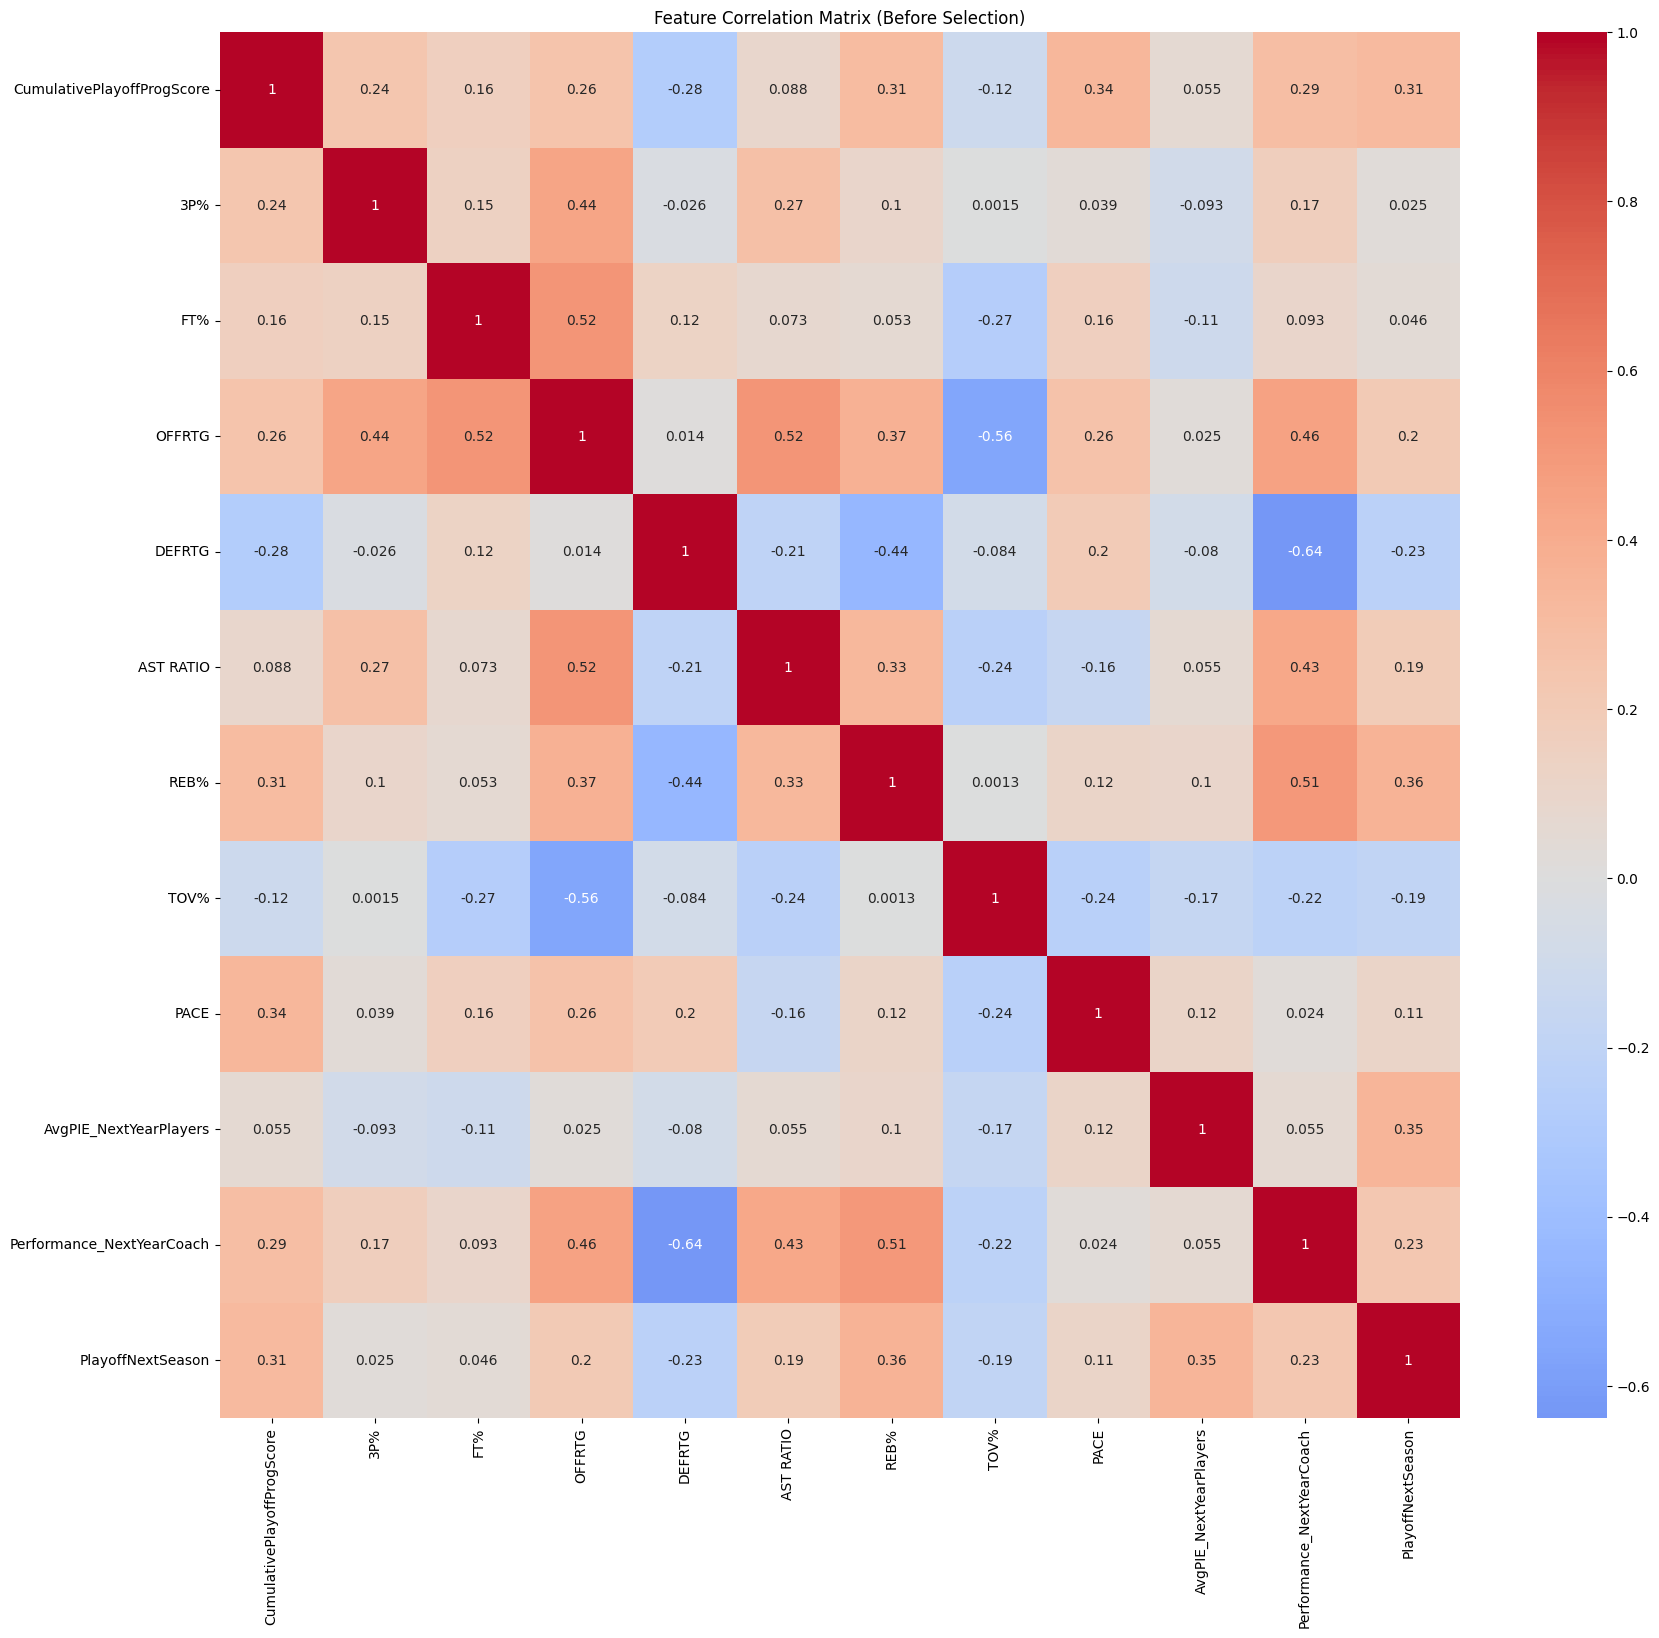

In [185]:
# ============================
# Display Initial Correlation Matrix
# ============================

# Calculate and plot the correlation matrix
correlation_matrix = dataset[features + [label]].corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Before Selection)')
plt.show()

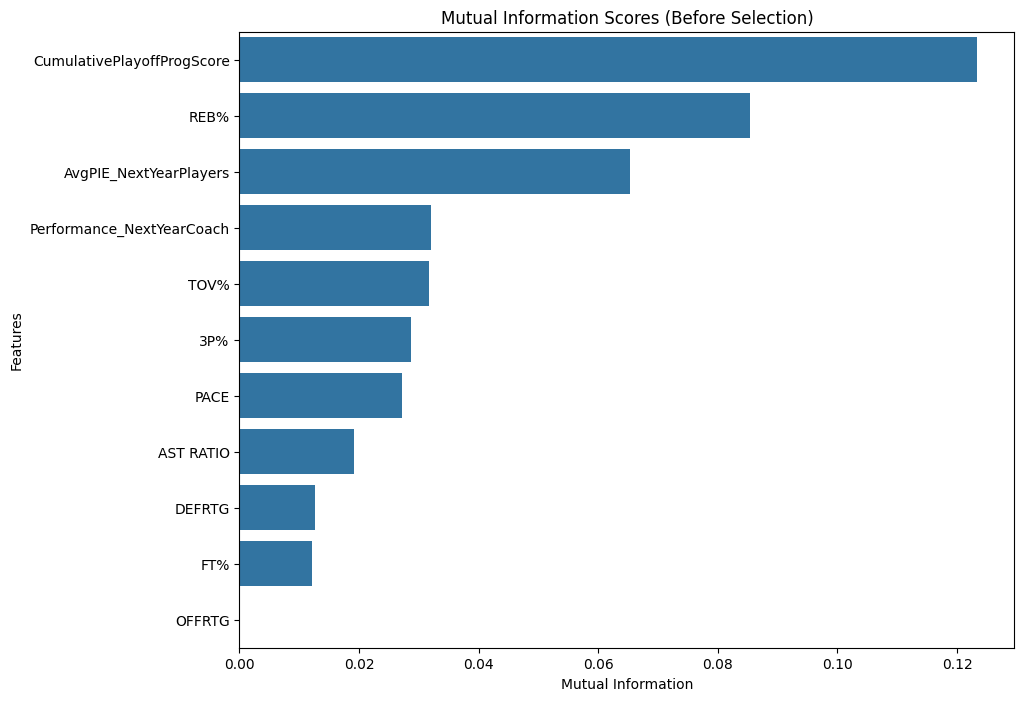

In [186]:
# ============================
# Display Initial Mutual Information Scores
# ============================

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns, name='MI Scores')
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.title('Mutual Information Scores (Before Selection)')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

In [187]:
'''
# ============================
# Correlation Filtering
# ============================

# Calculate the correlation matrix
correlation_matrix = X.corr()
correlation_threshold = 0.9
correlated_features = set()

# Identify features with correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(correlation_matrix.columns[i])

# Keep only non-correlated features
X = X.drop(columns=correlated_features)
print("Remaining features correlation filtering:", list(X))
'''

'\n# ============================\n# Correlation Filtering\n# ============================\n\n# Calculate the correlation matrix\ncorrelation_matrix = X.corr()\ncorrelation_threshold = 0.9\ncorrelated_features = set()\n\n# Identify features with correlation above the threshold\nfor i in range(len(correlation_matrix.columns)):\n    for j in range(i):\n        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:\n            correlated_features.add(correlation_matrix.columns[i])\n\n# Keep only non-correlated features\nX = X.drop(columns=correlated_features)\nprint("Remaining features correlation filtering:", list(X))\n'

In [188]:
'''
# ============================
# Mutual Information Filtering
# ============================

# Calculate mutual information
mutual_info = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mutual_info_series = pd.Series(mutual_info, index=X.columns)

# Set a threshold for mutual information
mi_threshold = 0.02
selected_features_mi = mutual_info_series[mutual_info_series > mi_threshold].index.tolist()

# Filter the dataset based on selected features
X = X[selected_features_mi]
print("Remaining features after mutual information filtering:", selected_features_mi)
'''

'\n# ============================\n# Mutual Information Filtering\n# ============================\n\n# Calculate mutual information\nmutual_info = mutual_info_classif(X, y, discrete_features=\'auto\', random_state=42)\nmutual_info_series = pd.Series(mutual_info, index=X.columns)\n\n# Set a threshold for mutual information\nmi_threshold = 0.02\nselected_features_mi = mutual_info_series[mutual_info_series > mi_threshold].index.tolist()\n\n# Filter the dataset based on selected features\nX = X[selected_features_mi]\nprint("Remaining features after mutual information filtering:", selected_features_mi)\n'

In [189]:
# ============================
# Define the XGBoost model
# ============================

def create_model(trial):
    return XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        n_estimators=trial.suggest_int('n_estimators', 50, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
        gamma=trial.suggest_float('gamma', 0, 5),
        reg_alpha=trial.suggest_float('reg_alpha', 0, 1),
        reg_lambda=trial.suggest_float('reg_lambda', 0, 1),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 100)
    )

In [190]:
# Use StratifiedKFold to maintain class distribution in each fold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define specificity scorer
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(specificity)

# Define the scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

In [191]:
# ============================
# Hyperparameter Tuning with Optuna
# ============================

def objective(trial):
    model = create_model(trial)
    cv_results = cross_validate(model, X, y, cv=skf, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_auc = np.mean(cv_results['test_roc_auc'])

    return 0.5 * mean_accuracy + 0.5 * mean_auc

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs=-1)

# Use the best hyperparameters to create the final model
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best Value:", study.best_value)
final_model = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
#final_model = XGBClassifier(
#    learning_rate=0.1,       # Step size shrinkage
#    n_estimators=100,        # Number of trees
#    max_depth=6,             # Maximum depth of trees
#    min_child_weight=1,      # Minimum sum of instance weight (hessian) in a child
#    subsample=0.8,           # Subsample ratio of training data
#    colsample_bytree=0.8,    # Subsample ratio of features per tree
#    gamma=0,                 # Minimum loss reduction to make a split
#    reg_alpha=0,             # L1 regularization
#    reg_lambda=1,            # L2 regularization
#    scale_pos_weight=1,      # Used for imbalanced datasets; adjust if needed
#    random_state=42,         # Ensures reproducibility
#    verbosity=1              # Controls the output verbosity
#)

[I 2024-12-10 12:14:43,723] A new study created in memory with name: no-name-847e7815-8eef-4315-89d6-df9e33a4c9d7
[I 2024-12-10 12:14:44,027] Trial 0 finished with value: 0.6607312925170068 and parameters: {'learning_rate': 0.04131709199135285, 'n_estimators': 311, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8073562466393733, 'colsample_bytree': 0.9235367974755121, 'gamma': 4.121687442520953, 'reg_alpha': 0.09157715027112823, 'reg_lambda': 0.28155107469517215, 'scale_pos_weight': 99.33129374951825}. Best is trial 0 with value: 0.6607312925170068.
[I 2024-12-10 12:14:44,043] Trial 1 finished with value: 0.7146853741496598 and parameters: {'learning_rate': 0.1949096349490067, 'n_estimators': 129, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5949807159550581, 'colsample_bytree': 0.7283775052784429, 'gamma': 0.9621622346271297, 'reg_alpha': 0.24408769890271464, 'reg_lambda': 0.34587216745373683, 'scale_pos_weight': 87.71194764210388}. Best is trial 1 with value: 0.7146

Best Hyperparameters: {'learning_rate': 0.2242647022315775, 'n_estimators': 79, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8927217522311153, 'colsample_bytree': 0.7750851408245816, 'gamma': 0.4593480844032318, 'reg_alpha': 0.4090488353340545, 'reg_lambda': 0.08331747739058343, 'scale_pos_weight': 8.196181010536847}
Best Value: 0.8288180272108843


,Feature,Average Importance
6,REB%,0.142957
0,CumulativePlayoffProgScore,0.102181
5,AST RATIO,0.101573
9,AvgPIE_NextYearPlayers,0.097093
7,TOV%,0.093102
4,DEFRTG,0.086608
3,OFFRTG,0.083446
8,PACE,0.078863
1,3P%,0.076505
2,FT%,0.072008


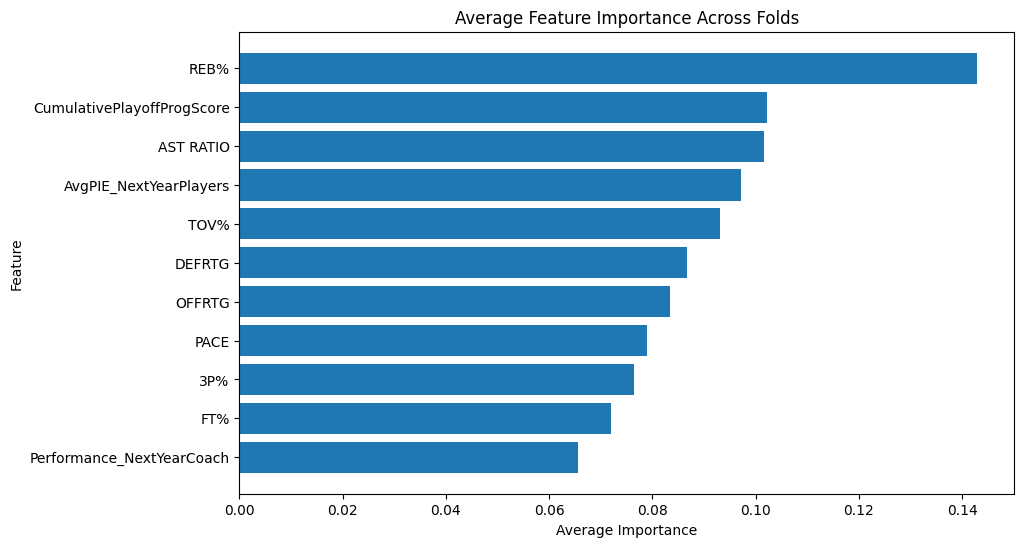

Mean Cross-Validation Accuracy: 0.8109523809523809
Mean Cross-Validation Precision: 0.7619444444444444
Mean Cross-Validation Recall: 0.9142857142857144
Mean Cross-Validation F1 Score: 0.8297222222222222
Mean Cross-Validation AUC Score: 0.8466836734693878
Mean Cross-Validation Specificity: 0.7071428571428571


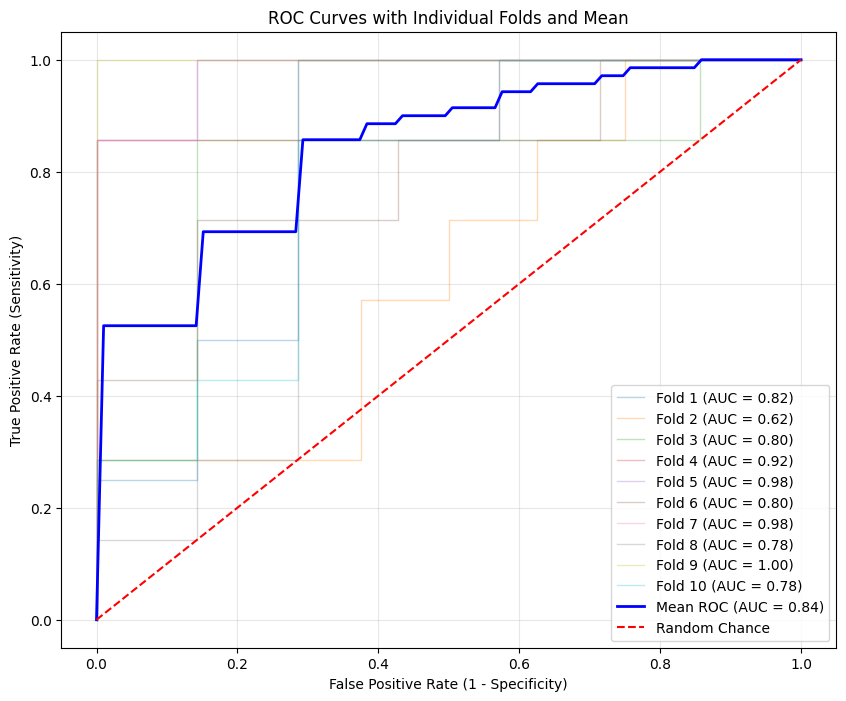

In [192]:
# ============================
# Final Evaluation
# ============================
cv_results = cross_validate(
    final_model, X, y, cv=skf, scoring=scoring, return_estimator=True, n_jobs=-1
)

feature_importances = []
for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

average_importances = np.mean(feature_importances, axis=0)

feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
}).sort_values(by='Average Importance', ascending=False)

# Display the feature importance table
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Average Importance'])
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Average Feature Importance Across Folds')
plt.gca().invert_yaxis()
plt.show()

print("Mean Cross-Validation Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Cross-Validation Precision:", cv_results['test_precision'].mean())
print("Mean Cross-Validation Recall:", cv_results['test_recall'].mean())
print("Mean Cross-Validation F1 Score:", cv_results['test_f1'].mean())
print("Mean Cross-Validation AUC Score:", cv_results['test_roc_auc'].mean())
print("Mean Cross-Validation Specificity:", cv_results['test_specificity'].mean())

# ROC Curve Visualization with Individual Folds
plt.figure(figsize=(10, 8))
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    final_model.fit(X_train, y_train)
    y_proba = final_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# Plot the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()